In [1]:
import config
import numpy as np
from sklearn import metrics
from tensorflow.keras.callbacks import History

In [2]:
# 读入预处理好的数据
Train_seq = np.load(config.train_sequence_path)[0]
Train_tags_set = np.load(config.train_tags_path)
Train_label_set = np.load(config.train_label_path)
Validation_seq = np.load(config.validation_sequence_path)[0]
Validation_tags_set = np.load(config.validation_tags_path)
Validation_label = np.load(config.validation_label_path)

Train_seq = Train_seq[:, :config.input_nodes]
Validation_seq = Validation_seq[:, :config.input_nodes]

In [3]:
from model import TextClassifier

Using TensorFlow backend.


In [4]:
# from tqdm import tqdm

# Train_seq_set_ = []
# for i in tqdm(range(Train_seq_set.shape[0])):
#     seq = Train_seq_set[i]
#     seq_ = []
#     for j in range(3):
#         seq_.extend(seq[j:j+198])
#     Train_seq_set_.append(seq_)
# Train_seq_set_ = np.array(Train_seq_set_)

# Validation_seq_ = []
# for i in tqdm(range(Validation_seq.shape[0])):
#     seq = Validation_seq[i]
#     seq_ = []
#     for j in range(3):
#         seq_.extend(seq[j:j+198])
#     Validation_seq_.append(seq_)
# Validation_seq_ = np.array(Validation_seq_)

In [5]:
from sklearn.utils.class_weight import compute_sample_weight

sample_weights = []
for i in range(20):
    label = Train_label_set[i]
    label[label == -1] = 2
    label[label == -2] = 3
    sample_weights.append(compute_sample_weight('balanced', label))
    
    sample_weights[i][sample_weights[i]>5] = 5
    sample_weights[i][sample_weights[i]<0.6] = 0.6    
# for i in range(20):
#     print(np.unique(sample_weights[i]))

In [7]:
clf = TextClassifier(embedding_weights=True,sample_weights=sample_weights)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 550)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 550, 300)     66876600    input_1[0][0]                    
__________________________________________________________________________________________________
cu_dnngru (CuDNNGRU)            (None, 550, 128)     165120      embedding[0][0]                  
__________________________________________________________________________________________________
cu_dnngru_2 (CuDNNGRU)          (None, 550, 128)     165120      embedding[0][0]                  
__________________________________________________________________________________________________
cu_dnngru_

In [8]:
# clf.model.load_weights('models/20bigru128_capsule-10-16-5_fc643.h5')
# clf.model.load_weights('models/20bigru128_sequences_bigru128_capsule-10-16-5_fc64_4.h5')

In [9]:
import tensorflow.keras.backend as K
LRs = [0.001, 0.002, 0.002, 0.001, 0.0005, 0.0002, 0.0001, 0.00005]
H = []
for t in range(len(LRS)):
    hist = clf.train(Train_seq, [Train_label_set[i] for i in range(20)], 
                     Validation_seq, [Validation_label[i] for i in range(20)])
    
    y_pred = []
    y_true = []
    y_pred = clf.model.predict(Validation_seq)
    y_pred = [np.argmax(y_pred[i], axis=1) for i in range(20)]
    y_true = [np.argmax(Validation_label[i], axis=1) for i in range(20)]
    _f1 = [metrics.f1_score(y_true[i], y_pred[i], average='macro') for i in range(len(y_pred))]    
    
    print('======F1 Scores======')
    for i in range(20):
        print('{}: {}'.format(i+1, round(_f1[i], 4)))
    print('---------------------')
    print("Avg: {}".format(round(np.average(_f1), 4)))
    print('=====================')
    
    H.append(clf.model.history.history)
    
#     K.set_value(clf.model.optimizer.lr, LRs[t])
    
    model_name = '20bigru128_sequences_bigru128_capsule-10-16-5_fc64_trainEmbedding'
    clf.model.save_weights('models/{}_{}_{}.h5'.format(model_name, 
                                                       str(t), 
                                                       str(round(np.average(_f1),4))))

/home/donald/anaconda3/envs/tf36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 105000 samples, validate on 15000 samples
Epoch 1/1
105000/105000 [==============================] - 4308s 41ms/step - loss: 5.8894 - dense_1_loss: 0.1306 - dense_3_loss: 0.2700 - dense_5_loss: 0.1880 - dense_7_loss: 0.1991 - dense_9_loss: 0.2857 - dense_11_loss: 0.0561 - dense_13_loss: 0.1850 - dense_15_loss: 0.4158 - dense_17_loss: 0.2817 - dense_19_loss: 0.3391 - dense_21_loss: 0.2913 - dense_23_loss: 0.3234 - dense_25_loss: 0.3583 - dense_27_loss: 0.2918 - dense_29_loss: 0.4919 - dense_31_loss: 0.3926 - dense_33_loss: 0.4632 - dense_35_loss: 0.2538 - dense_37_loss: 0.3956 - dense_39_loss: 0.2766 - dense_1_f1: 0.5506 - dense_1_categorical_accuracy: 0.9591 - dense_3_f1: 0.4222 - dense_3_categorical_accuracy: 0.8978 - dense_5_f1: 0.6541 - dense_5_categorical_accuracy: 0.9372 - dense_7_f1: 0.5629 - dense_7_categorical_accuracy: 0.9372 - dense_9_f1: 0.8126 - dense_9_categorical_accuracy: 0.8950 - dense_11_f1: 0.5118 - dense_11_categorical_accuracy: 0.9835 - dense_13_f1: 0.6242 

/home/donald/anaconda3/envs/tf36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


TypeError: must be str, not numpy.float64

In [10]:
model_name = '20bigru128_sequences_bigru128_capsule-10-16-5_fc64_trainEmbedding'
clf.model.save_weights('models/{}_{}_{}.h5'.format(model_name, 
                                                       str(t), 
                                                       str(round(np.average(_f1),4))))

In [1]:
clf.model.history.history.keys()

NameError: name 'clf' is not defined

In [10]:
nums = [2*i+1 for i in range(20)]
f1 = [clf.model.history.history['val_dense_'+str(nums[i])+'_f1'] for i in range(20)]
acc_train = [clf.model.history.history['dense_'+str(nums[i])+'_categorical_accuracy'] 
             for i in range(20)]
acc_valid = [clf.model.history.history['val_dense_'+str(nums[i])+'_categorical_accuracy'] 
             for i in range(20)]
loss_train = [clf.model.history.history['dense_'+str(nums[i])+'_loss'] for i in range(20)]
loss_valid = [clf.model.history.history['val_dense_'+str(nums[i])+'_loss'] for i in range(20)]

f1_ = np.mean(f1, axis=0)
acc_train_ = np.mean(acc_train, axis=0)
acc_valid_ = np.mean(acc_valid, axis=0)
loss_train_ = np.mean(loss_train, axis=0)
loss_valid_ = np.mean(loss_valid, axis=0)
num_epochs = len(f1[0])

In [11]:
import matplotlib
from matplotlib import pyplot as plt

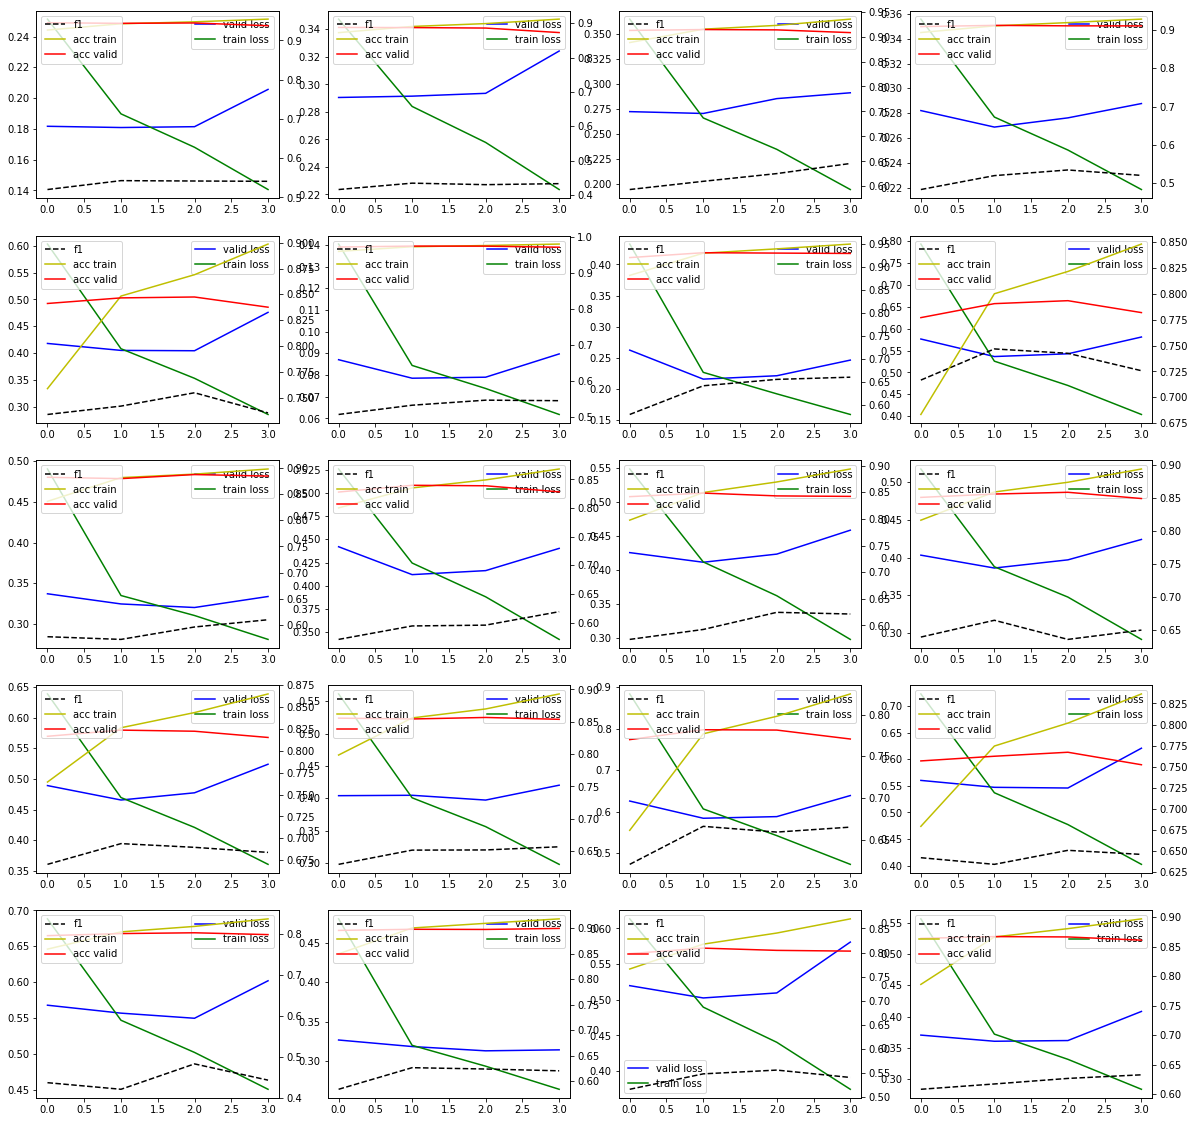

In [12]:
fig, axes = plt.subplots(5,4, figsize=(20,20))
for i in range(20):
#     fig, cur_axis = plt.subplots()
    cur_axis = axes[i//4][i%4]
    cur_axis.plot(range(num_epochs),loss_valid[i], 'b', label='valid loss')
    cur_axis.plot(range(num_epochs), loss_train[i], 'g',label='train loss')
    cur_axis.legend()

    cur_axis1 = cur_axis.twinx()
    cur_axis1.plot(range(num_epochs), f1[i], 'k--',label='f1')
    cur_axis1.plot(range(num_epochs), acc_train[i], 'y', label='acc train')
    cur_axis1.plot(range(num_epochs), acc_valid[i], 'r', label='acc valid')
    cur_axis1.legend(loc='upper left')

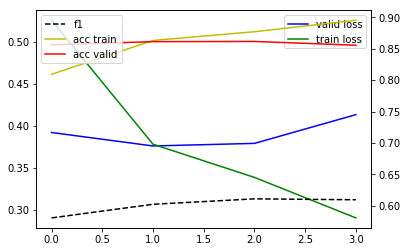

In [13]:
fig, ax1 = plt.subplots()
ax1.plot(range(num_epochs),loss_valid_, 'b', label='valid loss')
ax1.plot(range(num_epochs), loss_train_, 'g',label='train loss')
plt.legend()

ax2 = ax1.twinx()
ax2.plot(range(num_epochs), f1_, 'k--',label='f1')
ax2.plot(range(num_epochs), acc_train_, 'y', label='acc train')
ax2.plot(range(num_epochs), acc_valid_, 'r', label='acc valid')
plt.legend(loc='upper left')

In [14]:
max(np.mean(f1, axis=0))

0.6112473066413403

In [ ]:
y_pred = []
y_true = []
y_pred = clf.model.predict(Validation_seq)
y_pred = [np.argmax(y_pred[i], axis=1) for i in range(20)]
y_true = [np.argmax(Validation_label[i], axis=1) for i in range(20)]
f1 = [metrics.f1_score(y_true[i], y_pred[i], average='macro') for i in range(len(y_pred))]
# print("F1 Score:",f1)

In [ ]:
for i in range(20):
    print('{}: {}'format(i+1, str(f1[i])))
print(np.average(f1))

In [10]:
from sklearn.metrics import accuracy_score

In [15]:
for i in range(20):
    print(accuracy_score(y_true=y_true[i], y_pred=y_pred[i]))

0.9402
0.8867333333333334
0.9098
0.9122
0.8509333333333333
0.9750666666666666
0.9321333333333334
0.8005333333333333
0.8843333333333333
0.832
0.85
0.8652
0.831
0.8575333333333334
0.7894
0.7702666666666667
0.8032666666666667
0.9004
0.8151333333333334
0.8680666666666667


In [17]:
from tensorflow.keras.utils import plot_model

In [18]:
plot_model(clf.model, to_file='experiments/yxl.png')

In [23]:
clf.model.history.epoch

[]

In [8]:
import tensorflow.keras.backend as K

In [24]:
np.array(True, dtype=np.bool)

array(True)

In [9]:
K.set_value(clf.model.layers[1].trainable, np.array(True, dtype=np.bool))

AttributeError: 'numpy.dtype' object has no attribute 'base_dtype'

In [9]:
K.set_value(clf.model.optimizer.lr, 0.01)

In [ ]:
from tensorflow.keras.models import load_model, load_

In [10]:
# clf.model.save_weights('models/DPCNN_5.h5')

In [6]:
clf.model.load_weights('models/DPCNN_1022_6.h5')

In [10]:
import pandas as pd
Train_raw_data = pd.read_csv(config.train_data_path)
label_names = Train_raw_data.keys().tolist()
label_names.remove('id')
label_names.remove('content')

In [11]:
Test_sequence = np.load(config.test_sequence_path)
test_pred = clf.model.predict(Test_sequence[0])

ans = np.argmax(test_pred, axis=2)

ans[ans==2] = -1
ans[ans==3] = -2

for j in range(len(label_names)):
    Test_raw_data[label_names[j]] = ans[j]

Test_raw_data.to_csv("submission_v2.csv",index = False)

In [44]:
temp_sub = pd.read_csv('submission_v2.csv')

In [49]:
ans[0]

array([-2, -2, -2, ..., -2, -2,  1])